


# Finding star systems likely to contain habitable planets

In this notebook, I will build models to assess the likelyhood that a star system with at least one planet also has a habitable planet.

## Methods

I will use XGBoost primarily. Shapley plots will be used for feature importance exploration. Data is from NASA and the University of Puerto Rico at Arecibo's Planetary Habitability Lab.


# Installation of packages and libraries

In [1]:
pip install -U matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.1.3)


In [2]:
pip install shap

In [3]:
pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [4]:
!pip install pandas-profiling


In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import category_encoders as ce
import seaborn as sns
import pandas_profiling as pp
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

In [0]:
import shap

# Importing Data

In [0]:
# NASA Data

df = pd.read_csv('https://query.data.world/s/iukgz55lfeezloq4hbyupzrliqism6')

# University of Puerto Rico at Arecibo's data

df_2 = pd.read_csv('http://www.hpcf.upr.edu/~abel/phl/hec2/database/phl_exoplanet_catalog.csv')

In [8]:
df.shape, df_2.shape

((4108, 82), (4048, 112))

In [9]:
df_2['P_HABITABLE'].value_counts()

0    3993
2      34
1      21
Name: P_HABITABLE, dtype: int64

# Cleaning up the data


In [0]:
habitable = df_2[['P_NAME', 'P_HABZONE_CON', 'P_HABZONE_OPT', 'P_HABITABLE', 'P_ESI']].copy()


df['pl_name'] = df['pl_name'].str.lower()

habitable['P_NAME'] = habitable['P_NAME'].str.lower()


planets = pd.merge(df,habitable, how='inner', left_on='pl_name', right_on='P_NAME')

# Data exploration

In [11]:
planets['P_HABITABLE'].value_counts(dropna = False)

0    3982
2      33
1      19
Name: P_HABITABLE, dtype: int64

In [12]:
planets.shape

(4034, 87)

In [13]:
habitable.shape

(4048, 5)

In [14]:
  df.shape

(4108, 82)

In [15]:
df_2[df_2['P_HABITABLE'] == 2].head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,P_SEMI_MAJOR_AXIS,P_SEMI_MAJOR_AXIS_ERROR_MIN,P_SEMI_MAJOR_AXIS_ERROR_MAX,P_ECCENTRICITY,P_ECCENTRICITY_ERROR_MIN,P_ECCENTRICITY_ERROR_MAX,P_INCLINATION,P_INCLINATION_ERROR_MIN,P_INCLINATION_ERROR_MAX,P_OMEGA,P_OMEGA_ERROR_MIN,P_OMEGA_ERROR_MAX,P_TPERI,P_TPERI_ERROR_MIN,P_TPERI_ERROR_MAX,P_ANGULAR_DISTANCE,P_IMPACT_PARAMETER,P_IMPACT_PARAMETER_ERROR_MIN,P_IMPACT_PARAMETER_ERROR_MAX,P_TEMP_MEASURED,P_GEO_ALBEDO,P_GEO_ALBEDO_ERROR_MIN,P_GEO_ALBEDO_ERROR_MAX,P_DETECTION,P_DETECTION_MASS,P_DETECTION_RADIUS,P_ALT_NAMES,...,P_HILL_SPHERE,P_DISTANCE,P_PERIASTRON,P_APASTRON,P_DISTANCE_EFF,P_FLUX,P_FLUX_MIN,P_FLUX_MAX,P_TEMP_EQUIL,P_TEMP_EQUIL_MIN,P_TEMP_EQUIL_MAX,P_TYPE,S_RADIUS_EST,S_TYPE_TEMP,S_RA_H,S_RA_T,S_DEC_T,S_LUMINOSITY,S_HZ_OPT_MIN,S_HZ_OPT_MAX,S_HZ_CON_MIN,S_HZ_CON_MAX,S_HZ_CON0_MIN,S_HZ_CON0_MAX,S_HZ_CON1_MIN,S_HZ_CON1_MAX,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
137,GJ 163 c,3.0,6.801519,-0.899453,0.899453,NaN,NaN,NaN,2013,2017-01-26,25.63058,-0.0255,0.0255,0.12540,-0.00010,0.00010,0.099,-0.086,0.086,NaN,NaN,NaN,227.0,-79.87,79.87,2455057.7,-4.8,4.8,8.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,...,0.002906,0.126015,0.112985,0.137815,0.125554,1.253809,1.032992,1.536890,269.09231,256.84386,283.66492,Superterran,0.382000,M,4.154352,04 09 15.6663,-53 22 25.3164,0.019619,0.114563,0.297292,0.145111,0.281854,0.153842,0.281854,0.140070,0.281854,0.378188,0.029848,0.355307,1,0,Warm,2,0.686705,Dorado,Dor,Goldfish,2.499655,6.801519,0.12540
151,GJ 3293 d,3.0,7.599268,-1.048832,1.048832,NaN,NaN,NaN,2017,2017-03-30,48.13450,-0.0661,0.0628,0.19394,-0.00018,0.00017,0.120,-0.090,0.130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,...,0.004482,0.195336,0.170667,0.217213,0.194291,0.554036,0.438482,0.710269,219.20455,207.31605,233.88404,Superterran,0.400000,M,4.476588,04 28 35.7176,-25 10 09.4836,0.020688,0.117691,0.305921,0.149072,0.290035,0.158048,0.290035,0.143893,0.290035,0.388352,0.028616,0.345489,1,1,Warm,2,0.619738,Eridanus,Eri,River,2.668393,7.599268,0.19394
159,GJ 357 d,3.0,6.099119,-1.001158,1.001158,NaN,NaN,NaN,2019,2019-08-01,55.66100,-0.0550,0.0550,0.20400,-0.01500,0.01500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,...,0.005342,0.204000,0.204000,0.204000,0.204000,0.375611,0.375611,0.375611,199.44790,199.44790,199.44790,Superterran,0.340000,M,9.600455,09 36 01.6388,-21 39 38.8692,0.015631,0.102252,0.265280,0.129517,0.251505,0.137310,0.251505,0.125019,0.251505,0.337569,0.028518,0.321991,1,1,Warm,2,0.571287,Hydra,Hya,Water Snake,2.344216,6.099119,0.20400
189,GJ 832 c,3.0,5.403076,-0.953484,0.953484,NaN,NaN,NaN,2014,2014-06-25,35.68000,-0.0300,0.0300,0.16300,-0.00600,0.00600,0.180,-0.130,0.130,NaN,NaN,NaN,10.0,-47.00,47.00,NaN,NaN,NaN,32.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,...,0.003061,0.165641,0.133660,0.192340,0.163667,1.223480,0.864332,1.789851,266.29863,245.64903,294.67897,Superterran,0.495571,M,21.559439,21 33 33.9811,-49 00 32.4216,0.031976,0.146305,0.380188,0.185317,0.360445,0.196474,0.360445,0.178879,0.360445,0.482807,0.029585,0.353526,1,0,Warm,2,0.727791,Grus,Gru,Crane,2.182734,5.403076,0.16300
740,HD 40307 g,3.0,7.087565,-2.606190,2.606190,NaN,NaN,NaN,2013,2014-05-14,197.80000,-9.0000,5.7000,0.60000,-0.03300,0.03400,0.290,-0.290,0.310,NaN,NaN,NaN,91.7,NaN,NaN,NaN,NaN,NaN,46.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,...,0.008930,0.625230,0.426000,0.774000,0.606489,1.119638,0.643906,2.125618,257.81584,228.21833,307.62116,Superterran,0.844783,K,5.901178,05 54 04.2419,-60 01 24.4992,0.385749,0.487488,1.180710,0.617476,1.119418,0.653496,1.

In [16]:
habitable.head()

,P_NAME,P_HABZONE_CON,P_HABZONE_OPT,P_HABITABLE,P_ESI
0,11 com b,0,0,0,0.083813
1,11 umi b,0,0,0,0.082414
2,14 and b,0,0,0,0.081917
3,14 her b,0,0,0,0.145241
4,16 cyg b b,1,1,0,0.368627


In [17]:
df_2.describe()

,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,P_SEMI_MAJOR_AXIS,P_SEMI_MAJOR_AXIS_ERROR_MIN,P_SEMI_MAJOR_AXIS_ERROR_MAX,P_ECCENTRICITY,P_ECCENTRICITY_ERROR_MIN,P_ECCENTRICITY_ERROR_MAX,P_INCLINATION,P_INCLINATION_ERROR_MIN,P_INCLINATION_ERROR_MAX,P_OMEGA,P_OMEGA_ERROR_MIN,P_OMEGA_ERROR_MAX,P_TPERI,P_TPERI_ERROR_MIN,P_TPERI_ERROR_MAX,P_ANGULAR_DISTANCE,P_IMPACT_PARAMETER,P_IMPACT_PARAMETER_ERROR_MIN,P_IMPACT_PARAMETER_ERROR_MAX,P_TEMP_MEASURED,P_GEO_ALBEDO,P_GEO_ALBEDO_ERROR_MIN,P_GEO_ALBEDO_ERROR_MAX,P_DETECTION_MASS,P_DETECTION_RADIUS,P_ALT_NAMES,P_ATMOSPHERE,S_RA,S_DEC,...,S_TEMPERATURE_ERROR_MAX,S_DISC,S_MAGNETIC_FIELD,S_LOG_G,P_ESCAPE,P_POTENTIAL,P_GRAVITY,P_DENSITY,P_HILL_SPHERE,P_DISTANCE,P_PERIASTRON,P_APASTRON,P_DISTANCE_EFF,P_FLUX,P_FLUX_MIN,P_FLUX_MAX,P_TEMP_EQUIL,P_TEMP_EQUIL_MIN,P_TEMP_EQUIL_MAX,S_RADIUS_EST,S_RA_H,S_LUMINOSITY,S_HZ_OPT_MIN,S_HZ_OPT_MAX,S_HZ_CON_MIN,S_HZ_CON_MAX,S_HZ_CON0_MIN,S_HZ_CON0_MAX,S_HZ_CON1_MIN,S_HZ_CON1_MAX,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE,P_ESI,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
count,4048.0,1598.000000,1467.000000,1467.000000,3139.000000,3105.000000,3105.000000,4048.000000,3.938000e+03,3.807000e+03,3.807000e+03,2367.00000,1563.000000,1564.000000,1380.000000,971.000000,971.000000,844.000000,812.000000,810.000000,746.000000,693.000000,693.000000,4.810000e+02,472.000000,472.000000,2361.000000,1409.000000,1407.000000,1407.000000,5.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,4048.000000,4048.000000,...,3680.000000,0.0,0.0,3575.0000,706.000000,706.000000,706.000000,706.000000,1546.000000,3978.000000,3978.000000,3978.000000,3978.000000,3.721000e+03,3.721000e+03,3.721000e+03,3721.000000,3721.000000,3721.000000,3844.000000,4048.000000,3.786000e+03,3786.000000,3786.000000,3786.000000,3786.000000,3786.000000,3786.000000,3786.000000,3786.000000,3786.000000,3.083000e+03,3281.000000,4048.000000,4048.000000,4048.000000,3721.000000,4048.000000,4048.000000,3978.000000
mean,3.0,798.384920,-152.292232,190.289692,4.191426,-0.483990,0.621867,2014.212945,2.309342e+03,-1.073631e+03,1.043257e+03,6.62603,-0.422790,0.417806,0.161551,-0.054147,0.064746,86.228927,-1.074639,1.018000,135.405294,-37.777477,41.399581,2.429249e+06,-143.804175,170.483285,192.953976,0.403195,-0.186633,0.184044,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,245.143596,23.513995,...,99.923255,NaN,NaN,4.3428,5.357040,59.308332,14.440209,6.449325,1.834750,4.047677,3.884638,4.138132,4.022928,6.166291e+02,6.040859e+02,6.439591e+02,804.193202,793.683032,824.937273,1.539951,16.342907,5.786277e+00,0.990972,2.369724,1.255196,2.246710,1.327826,2.246710,1.211666,2.246710,3.513348,1.768991e+35,0.440103,0.049654,0.034091,0.021986,0.261252,5.588647,323.089993,4.011385
std,0.0,1406.808654,783.366353,1082.061976,4.776830,1.409048,2.007592,3.704839,1.167012e+05,5.943181e+04,5.923238e+04,80.78324,5.940422,5.662590,0.187948,0.050142,0.060515,8.410675,2.120326,2.986941,119.784620,45.859539,50.566626,2.492749e+05,658.397999,813.380691,3650.411292,0.264686,0.104331,0.104648,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,86.156500,32.451168,...,61.844821,NaN,NaN,0.5247,5.536594,194.200552,84.244319,45.536970,21.032523,62.435994,62.341847,62.519336,62.404512,1.141227e+04,1.141123e+04,1.141622e+04,459.516962,459.536615,462.418561,3.683358,5.743767,4.923779e+01,1.617972,4.031176,2.049408,3.821896,2.170521,3.821896,1.978427,3.821896,5.463171,6.944274e+36,0.074285,0.217256,0.181485,0.195731,0.131333,5.392733,965.084290,62.389968
min,3.0,0.019070,-24965.390000,0.000000,0.336300,-54.592700,0.000000,1989.000000,9.070629e-02,-3.650000e+06,0.000000e+00,0.00440,-200.000000,0.000000,0.000000,-0.470000,0.000000,7.700000,-25.000000,0.000000,-233.000000,-320.900000,0.000000,0.000000e+00,-9600.000000,0.000000,0.000000,-0.629000,-0.760000,0.000000,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.325750,-84.231613,...,0.000000,NaN,NaN,-4.9950,0.355921,0.126680,0.044185,0.005665,

In [18]:
df_2['P_TYPE'].value_counts()

Jovian         1302
Superterran    1099
Neptunian       898
Terran          673
Subterran        58
Miniterran        1
Name: P_TYPE, dtype: int64

#Star System Data Exploration

In [0]:
stars = planets['pl_hostname'].value_counts()

In [20]:
stars

TRAPPIST-1     7
Kepler-11      6
HD 10180       6
HD 219134      6
HD 34445       6
              ..
HD 133131 B    1
Kepler-844     1
Kepler-824     1
Kepler-1233    1
Kepler-591     1
Name: pl_hostname, Length: 3006, dtype: int64

In [0]:
starsystems_counts =  stars[stars > 1]

In [22]:
starsystems_counts['tau Cet']

4

In [23]:
planets[planets['pl_hostname'] == 'tau Cet']

,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmaxn,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccenn,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbincln,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassn,pl_bmassprov,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_radn,pl_dens,pl_denserr1,pl_denserr2,...,ra,st_raerr,dec,st_decerr,st_posn,st_dist,st_disterr1,st_disterr2,st_distlim,st_distn,st_optmag,st_optmagerr,st_optmaglim,st_optband,gaia_gmag,gaia_gmagerr,gaia_gmaglim,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_teffn,st_mass,st_masserr1,st_masserr2,st_masslim,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radn,pl_nnotes,rowupdate,pl_facility,P_NAME,P_HABZONE_CON,P_HABZONE_OPT,P_HABITABLE,P_ESI
2660,tau Cet,g,tau cet g,Radial Velocity,0,4,20.00,0.02,-0.01,0.0,1,0.133,0.001,-0.002,0.0,1,0.06,0.13,-0.06,0.0,1,NaN,NaN,NaN,0.0,0,0.00551,0.00079,-0.00126,0.0,1,Msini,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,...,26.017012,0.000002,-15.93748,0.000002,4,3.6,0.01,-0.01,0.0,4,3.5,NaN,0.0,V (Johnson),3.134,NaN,0.0,NaN,NaN,NaN,0.0,3,0.78,0.01,-0.01,0.0,4,NaN,NaN,NaN,0.0,3,0,2017-08-17,Multiple Observatories,tau cet g,0,0,0,0.342664
2661,tau Cet,h,tau cet h,Radial Velocity,0,4,49.41,0.08,-0.10,0.0,1,0.243,0.003,-0.003,0.0,1,0.23,0.16,-0.15,0.0,1,NaN,NaN,NaN,0.0,0,0.00576,0.00214,-0.00082,0.0,1,Msini,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,...,26.017012,0.000002,-15.93748,0.000002,4,3.6,0.01,-0.01,0.0,4,3.5,NaN,0.0,V (Johnson),3.134,NaN,0.0,NaN,NaN,NaN,0.0,3,0.78,0.01,-0.01,0.0,4,NaN,NaN,NaN,0.0,3,0,2017-08-17,Multiple Observatories,tau cet h,0,0,0,0.446574
2662,tau Cet,e,tau cet e,Radial Velocity,0,4,162.87,1.08,-0.46,0.0,1,0.538,0.060,-0.060,0.0,1,0.18,0.18,-0.14,0.0,1,NaN,NaN,NaN,0.0,0,0.01237,0.00261,-0.00201,0.0,1,Msini,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,...,26.017012,0.000002,-15.93748,0.000002,4,3.6,0.01,-0.01,0.0,4,3.5,NaN,0.0,V (Johnson),3.134,NaN,0.0,NaN,NaN,NaN,0.0,3,0.78,0.01,-0.01,0.0,4,NaN,NaN,NaN,0.0,3,0,2017-08-17,Multiple Observatories,tau cet e,0,1,1,0.737081
2663,tau Cet,f,tau cet f,Radial Velocity,0,4,636.13,11.70,-47.69,0.0,1,1.334,0.017,-0.044,0.0,1,0.16,0.07,-0.16,0.0,1,NaN,NaN,NaN,0.0,0,0.01237,0.00330,-0.00431,0.0,1,Msini,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,...,26.017012,0.000002,-15.93748,0.000002,4,3.6,0.01,-0.01,0.0,4,3.5,NaN,0.0,V (Johnson),3.134,NaN,0.0,NaN,NaN,NaN,0.0,3,0.78,0.01,-0.01,0.0,4,NaN,NaN,NaN,0.0,3,0,2017-08-17,Multiple Observatories,tau cet f,0,0,0,0.538662


In [0]:
starsystem_habitable = planets[(planets['P_HABITABLE'] > 0) & (planets['pl_hostname'].isin(starsystems_counts.index))]


starsystem_habitable_2 = planets[(planets['P_HABITABLE'] > 0) & (planets['pl_pnum'] > 1)]


star_habitable = planets[(planets['P_HABITABLE'] > 0) & (planets['pl_pnum'] == 1)]

In [25]:
starsystem_habitable.shape, star_habitable.shape, starsystem_habitable_2.shape

((31, 87), (21, 87), (31, 87))

In [26]:
starsystems_counts.shape

(679,)

In [27]:
starsystems_counts.index

Index(['TRAPPIST-1', 'Kepler-11', 'HD 10180', 'HD 219134', 'HD 34445',
       'Kepler-80', 'Kepler-20', 'Kepler-292', 'Kepler-238', 'Kepler-82',
       ...
       'Kepler-94', 'Kepler-419', 'Kepler-424', 'Kepler-347', 'K2-141',
       'Kepler-755', 'Kepler-291', 'Kepler-137', 'Kepler-241', 'Kepler-382'],
      dtype='object', length=679)

In [28]:
planets.pl_hostname.value_counts().loc[lambda x: x<2].index

Index(['MOA-2016-BLG-319L', 'Kepler-1144', 'K2-15', 'HD 42012', 'K2-150',
       'Kepler-674', 'HD 32518', 'Kepler-435', 'Kepler-600', 'Kepler-1240',
       ...
       'Kepler-1456', 'Kepler-422', 'HD 216435', 'WASP-42', 'HATS-66',
       'HD 133131 B', 'Kepler-844', 'Kepler-824', 'Kepler-1233', 'Kepler-591'],
      dtype='object', length=2327)

In [29]:
planets.pl_pnum.value_counts(dropna=False)

1    2319
2     908
3     429
4     229
5     105
6      36
7       7
8       1
Name: pl_pnum, dtype: int64

In [0]:
planets_habitable = planets[(planets['P_HABITABLE'] > 0)]

In [31]:
planets_habitable.pl_hostname.value_counts()

TRAPPIST-1          4
GJ 667 C            3
Teegarden's Star    2
Kepler-62           2
Kepler-296          2
GJ 3293             1
Kepler-1632         1
Proxima Cen         1
Kepler-283          1
Kepler-61           1
K2-9                1
K2-3                1
Kepler-1606         1
Kepler-1552         1
Kepler-442          1
Kepler-443          1
Kepler-1638         1
Kepler-1652         1
Wolf 1061           1
Kepler-705          1
Kepler-1540         1
Kepler-298          1
K2-72               1
GJ 273              1
Kepler-174          1
Kepler-26           1
tau Cet             1
Kepler-440          1
GJ 163              1
GJ 832              1
GJ 357              1
K2-288 B            1
Kepler-186          1
Kepler-1410         1
K2-18               1
Kepler-1090         1
Kepler-22           1
Kepler-1544         1
LHS 1140            1
Kepler-452          1
HD 40307            1
GJ 3323             1
Kepler-1229         1
Kepler-1653         1
Name: pl_hostname, dtype: int64

# Starsystem data wrangling

In [0]:
planets.rename(columns={'st_teff':'st_temp'}, inplace=True)


system_columns = ['pl_hostname', 'pl_letter', 'pl_pnum', 'st_mass', 'st_temp', 
                  'st_rad', 'pl_bmassj','pl_radj', 'pl_orbper', 'pl_orbsmax', 'target']


planet_columns = ['pl_hostname', 'pl_letter', 'pl_bmassj','pl_radj', 'pl_orbper', 'pl_orbsmax', 'target']       



star_columns = ['pl_hostname', 'st_mass', 'st_temp', 'st_rad', 'system_target', 'pl_pnum']


planets['target'] = planets['P_HABITABLE'] > 0


starsystems = planets[planets['pl_pnum'] > 1]


starsystems_small = starsystems[system_columns].copy()


flat_columns = star_columns.copy()

In [0]:

for x in ['b','c','d','e','f','g','h','i']:

  column_1 = 'pl_mass_' + x
  
  column_2 = 'pl_rad_' + x
  
  column_3 = 'pl_orbper_' + x
  
  column_4 = 'pl_orbsmax_' + x
  
  flat_columns = flat_columns + [column_1, column_2, column_3, column_4]
  

In [0]:
single_planets = planets[(planets['pl_pnum'] == 1) & (planets['P_HABITABLE'] > 0)][system_columns].copy()

single_planets['system_target'] = single_planets['target']

single_planets_stars = single_planets[star_columns]

single_planets_stars = single_planets_stars.drop(columns='pl_pnum')

single_planets_stars = single_planets_stars.reindex(columns=flat_columns)

single_planets_stars = single_planets_stars.set_index('pl_hostname')

In [0]:
single_planets_unhab = planets[(planets['pl_pnum'] == 1) & (planets['P_HABITABLE'] == 0)][system_columns].copy()

single_planets_unhab['system_target'] = single_planets_unhab['target']

single_planets_unhab_stars = single_planets_unhab[star_columns]

single_planets_unhab_stars = single_planets_unhab_stars.drop(columns='pl_pnum')

single_planets_unhab_stars = single_planets_unhab_stars.reindex(columns=flat_columns)

single_planets_unhab_stars = single_planets_unhab_stars.set_index('pl_hostname')

In [0]:

starsystems_target_true = starsystems_small[starsystems_small['target'] == True]['pl_hostname'].copy()

starsystems_target_true.drop_duplicates(inplace=True)


In [0]:
systems_index = starsystems_small.index

starsystems_small_target = starsystems_small['pl_hostname'].isin(starsystems_target_true)

starsystems_small_target = starsystems_small_target.reindex(index = systems_index)
 
starsystems_small['system_target'] = starsystems_small_target

starsystems_small.sort_values(by='pl_hostname', inplace=True)

starsystems_stars =  starsystems_small[star_columns].copy()

starsystems_planets = starsystems_small[planet_columns].copy()

starsystems_planets_unhab = starsystems_planets[starsystems_planets['target'] == False]

starsystems_stars.drop_duplicates(inplace=True)

starsystems_flat = starsystems_stars.copy()

starsystems_flat = starsystems_flat.reindex(columns = flat_columns)

starsystems_flat = starsystems_flat.set_index('pl_hostname')

In [38]:
starsystems_flat.head()

,st_mass,st_temp,st_rad,system_target,pl_pnum,pl_mass_b,pl_rad_b,pl_orbper_b,pl_orbsmax_b,pl_mass_c,pl_rad_c,pl_orbper_c,pl_orbsmax_c,pl_mass_d,pl_rad_d,pl_orbper_d,pl_orbsmax_d,pl_mass_e,pl_rad_e,pl_orbper_e,pl_orbsmax_e,pl_mass_f,pl_rad_f,pl_orbper_f,pl_orbsmax_f,pl_mass_g,pl_rad_g,pl_orbper_g,pl_orbsmax_g,pl_mass_h,pl_rad_h,pl_orbper_h,pl_orbsmax_h,pl_mass_i,pl_rad_i,pl_orbper_i,pl_orbsmax_i
pl_hostname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24 Sex,1.54,5098.0,4.90,False,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47 UMa,1.03,5892.0,1.23,False,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55 Cnc,0.91,5196.0,0.94,False,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61 Vir,0.94,5577.0,0.96,False,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7 CMa,1.34,4826.0,4.87,False,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Making a new, flat dataframe with the each row one star, with columns for each
#  planet's radius, mass, orbital period, and orbital radius


for star in starsystems_flat.index:
  
  star_df = starsystems_planets_unhab[starsystems_planets_unhab['pl_hostname'] == star].copy()
  
  star_df = star_df.set_index('pl_letter')
  
  
  for x in star_df.index:  
    value = star_df.loc[x, 'pl_bmassj']  
    new_column = 'pl_mass_' + x
    starsystems_flat.loc[star, new_column] = value
  
  
  for x in star_df.index:
    value = star_df.loc[x, 'pl_radj']
    new_column = 'pl_rad_' + x
    starsystems_flat.loc[star, new_column] = value
  
  
  for x in star_df.index:
    value = star_df.loc[x, 'pl_orbper']
    new_column = 'pl_orbper_' + x
    starsystems_flat.loc[star, new_column] = value
  
  
  for x in star_df.index:
    value = star_df.loc[x, 'pl_orbsmax']
    new_column = 'pl_orbsmax_' + x
    starsystems_flat.loc[star, new_column] = value
    
  

# Solar System

In [0]:
# Making a dataframe for the solar system with data for the sun and all the 
#   non-Earth planets, taken from NASA.  Data is then converted to the right
#   units: years -> days and diameter and mass from Earths -> Jupiters


solar_system = pd.DataFrame(columns=system_columns)


solar_system['pl_letter'] = ['b','c','e','f','g','h', 'i']


solar_system['pl_orbsmax']=[ 0.387,	0.723, 1.52, 5.20, 9.58, 19.20, 30.05]


orbit_years = [0.241, 0.615, 1.88, 11.9, 29.4, 83.7, 163.7]
solar_system['pl_orbper'] = [y * 365 for y in orbit_years]


mass_earths = [0.0553, 0.815, 0.107, 317.8, 95.2, 14.5, 17.1]
solar_system['pl_bmassj'] = [m / 317.8 for m in mass_earths]


diameter_earths = [0.383, 0.949, 0.532, 11.21, 9.45, 4.01, 3.88]
solar_system['pl_radj'] = [r / 11.21 for r in diameter_earths]

In [0]:
# The solar values for the dataframe

solar_system['pl_hostname'] = 'sol'

solar_system['pl_pnum'] = 7

solar_system['st_mass'] = 1

solar_system['st_rad'] = 1

solar_system['st_temp'] = 5780

solar_system['system_target'] = True

In [0]:
solar_system_flat = solar_system[star_columns].copy()

solar_system_flat = solar_system_flat.reindex(columns = flat_columns)

solar_system_flat = solar_system_flat.set_index('pl_hostname')

In [0]:
# Flattening the Solar System dataframe

for star in solar_system_flat.index:

  star_df = solar_system
  star_df = star_df.set_index('pl_letter')


  for x in star_df.index:
    value = star_df.loc[x, 'pl_bmassj']
    new_column = 'pl_mass_' + x
    solar_system_flat.loc[star, new_column] = value


  for x in star_df.index:
    value = star_df.loc[x, 'pl_radj']
    new_column = 'pl_rad_' + x
    solar_system_flat.loc[star, new_column] = value


  for x in star_df.index:
    value = star_df.loc[x, 'pl_orbper']
    new_column = 'pl_orbper_' + x
    solar_system_flat.loc[star, new_column] = value


  for x in star_df.index:
    value = star_df.loc[x, 'pl_orbsmax']
    new_column = 'pl_orbsmax_' + x
    solar_system_flat.loc[star, new_column] = value


In [0]:
solar_system_flatter = solar_system_flat.drop_duplicates()

In [45]:
solar_system_flatter

,st_mass,st_temp,st_rad,system_target,pl_pnum,pl_mass_b,pl_rad_b,pl_orbper_b,pl_orbsmax_b,pl_mass_c,pl_rad_c,pl_orbper_c,pl_orbsmax_c,pl_mass_d,pl_rad_d,pl_orbper_d,pl_orbsmax_d,pl_mass_e,pl_rad_e,pl_orbper_e,pl_orbsmax_e,pl_mass_f,pl_rad_f,pl_orbper_f,pl_orbsmax_f,pl_mass_g,pl_rad_g,pl_orbper_g,pl_orbsmax_g,pl_mass_h,pl_rad_h,pl_orbper_h,pl_orbsmax_h,pl_mass_i,pl_rad_i,pl_orbper_i,pl_orbsmax_i
pl_hostname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sol,1,5780,1,True,7,0.000174,0.034166,87.965,0.387,0.002565,0.084657,224.475,0.723,NaN,NaN,NaN,NaN,0.000337,0.047458,686.2,1.52,1.0,1.0,4343.5,5.2,0.299559,0.842997,10731.0,9.58,0.045626,0.357716,30550.5,19.2,0.053807,0.34612,59750.5,30.05


In [0]:
sol_flat = solar_system_flat[['st_mass', 'st_temp', 'st_rad', 'system_target', 'pl_pnum']]
sol_flat = sol_flat.reindex(columns = flat_columns)

sol_flat.drop(columns='pl_hostname', inplace=True)

sol_flat_1 = sol_flat.drop_duplicates().copy()
sol_flat_1['pl_pnum'] = np.NaN

single_planets_stars = single_planets_stars.append(sol_flat_1)


#Starsystem models

In [47]:

train_system, test_system = train_test_split(starsystems_flat, train_size=0.80, test_size=0.20, 
                              stratify=starsystems_flat['system_target'], random_state=42)

# Oversampling stars with habitable planets and stars with ony one planet in 
#   the training set

train_system = train_system.append(single_planets_stars)
train_system = train_system.append(single_planets_stars)
train_system = train_system.append(single_planets_stars)
train_system = train_system.append(single_planets_unhab_stars)
#train_system = train_system.append(sol_flat)

# Adding the solar system (with planets) to the test set
test_system = test_system.append(solar_system_flatter)

columns_drop = ['system_target', 'pl_pnum']

X_train_system = train_system.drop(columns=columns_drop)
X_test_system = test_system.drop(columns=columns_drop)


y_train_system = train_system['system_target']
y_test_system = test_system['system_target']


model_system = XGBClassifier(n_estimators=200, random_state=42, n_jobs=-1)

model_system.fit(X_train_system, y_train_system)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
  
X_train_system.shape, X_test_system.shape, starsystems_flat.shape, single_planets_stars.shape

((2913, 35), (139, 35), (687, 37), (22, 37))

In [49]:

y_pred_system = model_system.predict(X_test_system)

y_prob_system = model_system.predict_proba(X_test_system)[:,1]


print(roc_auc_score(y_test_system, y_prob_system), '\n\n')


confusion_matrix(y_test_system, y_pred_system)

0.943609022556391 




array([[132,   1],
       [  3,   3]])

In [0]:
X_test_system_result = X_test_system.copy()

X_test_system_result['prediction'] = y_pred_system
X_test_system_result['prob'] = y_prob_system
X_test_system_result['true'] = y_test_system

In [51]:
X_test_system_result[X_test_system_result['prob'] > .3][['prediction', 'prob', 'true']]

,prediction,prob,true
pl_hostname,,,
GJ 1148,False,0.345963,False
K2-239,True,0.862197,False
GJ 3323,True,0.922962,True
K2-90,False,0.471767,False
Wolf 1061,True,0.878507,True
sol,True,0.516633,True


In [52]:
X_test_system_result[X_test_system_result['true'] > 0][['prediction', 'prob', 'true']]

,prediction,prob,true
pl_hostname,,,
GJ 163,False,0.138732,True
K2-18,False,0.077631,True
GJ 3323,True,0.922962,True
Kepler-298,False,0.133947,True
Wolf 1061,True,0.878507,True
sol,True,0.516633,True


In [53]:
X_test_system_result[X_test_system_result['prediction'] > 0][['prediction', 'prob', 'true']]

,prediction,prob,true
pl_hostname,,,
K2-239,True,0.862197,False
GJ 3323,True,0.922962,True
Wolf 1061,True,0.878507,True
sol,True,0.516633,True


In [54]:
# Confusion matrix if the probability threshold is 10% instead of 50%

y_pred_system_low_threshold = y_prob_system > .10

confusion_matrix(y_test_system, y_pred_system_low_threshold)

array([[118,  15],
       [  1,   5]])

In [55]:
# Confusion matrix if the probability threshold is 5% instead of 50%

y_pred_system_low_threshold = y_prob_system > .05

confusion_matrix(y_test_system, y_pred_system_low_threshold)

array([[113,  20],
       [  0,   6]])

#Simple star model

In [56]:

X_train_system_simple = train_system[['st_mass', 'st_temp', 'st_rad']]
X_test_system_simple = test_system[['st_mass', 'st_temp', 'st_rad']]


y_train_system_simple = train_system['system_target']
y_test_system_simple = test_system['system_target']


model_system_simple = XGBClassifier(n_estimators=200, random_state=42, n_jobs=-1)

model_system_simple.fit(X_train_system_simple, y_train_system_simple)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [57]:

y_pred_system_simple = model_system_simple.predict(X_test_system_simple)

y_prob_system_simple = model_system_simple.predict_proba(X_test_system_simple)[:,1]


print(roc_auc_score(y_test_system_simple, y_prob_system_simple), '\n\n')


confusion_matrix(y_test_system_simple, y_pred_system_simple)

0.9335839598997494 




array([[131,   2],
       [  4,   2]])

In [58]:
# Confusion matrix if the probability threshold is 10% instead of 50%

y_pred_system_simple_low_threshold = y_prob_system_simple > .1

confusion_matrix(y_test_system, y_pred_system_simple_low_threshold)

array([[119,  14],
       [  2,   4]])

In [59]:
# Confusion matrix if the probability threshold is 5% instead of 50%

y_pred_system_simple_low_threshold = y_prob_system_simple > .05

confusion_matrix(y_test_system, y_pred_system_simple_low_threshold)

array([[109,  24],
       [  0,   6]])

In [0]:
X_test_system_simple_result = X_test_system_simple.copy()

X_test_system_simple_result['prediction'] = y_pred_system_simple
X_test_system_simple_result['prob'] = y_prob_system_simple
X_test_system_simple_result['true'] = y_test_system_simple

In [61]:
X_test_system_simple_result[X_test_system_simple_result['true'] > 0]

,st_mass,st_temp,st_rad,prediction,prob,true
pl_hostname,,,,,,
GJ 163,0.40,3500.0,NaN,False,0.071002,True
K2-18,0.36,3457.0,0.41,False,0.115431,True
GJ 3323,0.16,3159.0,0.12,True,0.745908,True
Kepler-298,NaN,4465.0,0.58,False,0.087726,True
Wolf 1061,0.29,3342.0,0.31,True,0.754181,True
sol,1.00,5780.0,1.00,False,0.395144,True


In [62]:
X_test_system_simple_result[X_test_system_simple_result['prob'] > .5]

,st_mass,st_temp,st_rad,prediction,prob,true
pl_hostname,,,,,,
Kepler-446,0.22,3359.0,0.24,True,0.679171,False
K2-117,0.54,3778.0,0.51,True,0.615907,False
GJ 3323,0.16,3159.0,0.12,True,0.745908,True
Wolf 1061,0.29,3342.0,0.31,True,0.754181,True


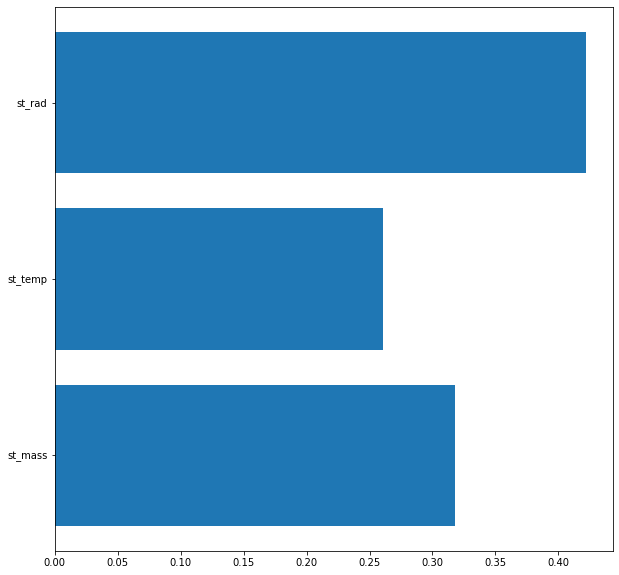

In [63]:
feature_importance_simple = model_system_simple.feature_importances_

%matplotlib inline
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.barh(X_test_system_simple.columns, feature_importance_simple)
plt.show()

#Shapley plots

In [65]:

row_s_simple = solar_system_flatter[['st_mass', 'st_temp', 'st_rad']].copy()
row_s_simple.columns = [['Mass', 'Temp', 'Radius']]

explainer = shap.TreeExplainer(model_system_simple, data= X_train_system_simple, model_output='probability')

shap_values_solar_simple = explainer.shap_values(row_s_simple)
# shap_values_sys_2 = explainer.shap_values(row_sys_2)

shap_values_solar_simple

Passing 2913 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


array([[0.07719895, 0.2431461 , 0.0459348 ]])

In [66]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_solar_simple, row_s_simple)

In [67]:
predicted_stars_simple = X_test_system_simple.copy()


shap_values_pos_simple = explainer.shap_values(predicted_stars_simple)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_pos_simple, predicted_stars_simple)


 97%|=================== | 135/139 [00:11<00:00]       

In [68]:
row_s = solar_system_flatter.drop(columns=columns_drop)
row_2 = X_test_system.loc['Wolf 1061']
model_system.predict_proba(row_s)

array([[0.48336697, 0.51663303]], dtype=float32)

In [69]:

explainer = shap.TreeExplainer(model_system, data= X_train_system, model_output='probability')

shap_values_solar = explainer.shap_values(row_s)
shap_values_2 = explainer.shap_values(row_2)

shap_values_solar

Passing 2913 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


array([[ 5.76607979e-02,  3.00809349e-01,  4.00333619e-02,
        -5.45103734e-04,  6.67454118e-03,  7.88776453e-03,
         1.37325064e-02,  1.22698984e-02,  4.07543818e-03,
        -5.75907894e-03, -8.22410635e-04,  2.23572173e-05,
         0.00000000e+00, -1.13460352e-04, -1.27560068e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  8.38081776e-03,  0.00000000e+00,
         4.49649169e-02,  0.00000000e+00, -2.39889541e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

In [70]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_solar, row_s)

In [71]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_2, row_2)

# Feature importance plots

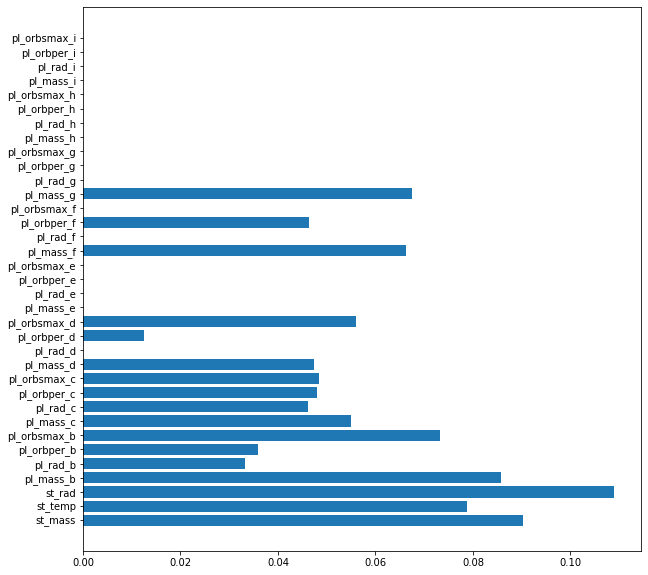

In [72]:
feature_importance_system = model_system.feature_importances_

%matplotlib inline
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.barh(X_test_system.columns, feature_importance_system)
plt.show()

In [73]:
predicted_stars = X_test_system.copy()

explainer = shap.TreeExplainer(model_system, data= X_train_system, model_output='probability')

shap_values_pos = explainer.shap_values(predicted_stars)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_pos, predicted_stars)


Passing 2913 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
 97%|=================== | 135/139 [00:13<00:00]       

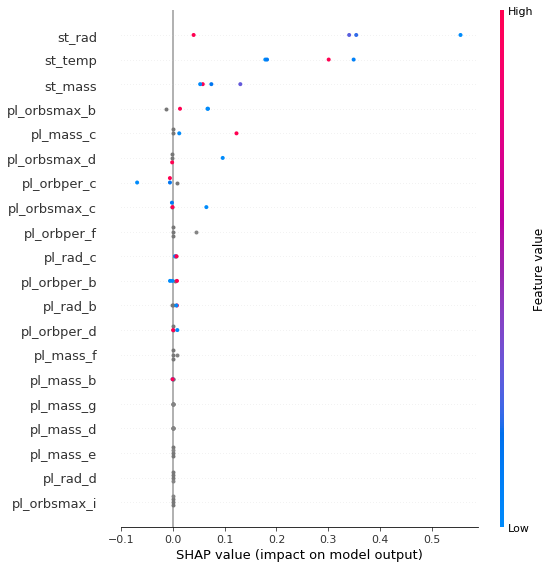

In [74]:
shap.initjs()
shap_all_values = explainer.shap_values(X_test_system[X_test_system_result['prediction'] > 0])

shap.summary_plot(shap_all_values,X_test_system[X_test_system_result['prediction'] > 0], feature_names=X_test_system.columns);

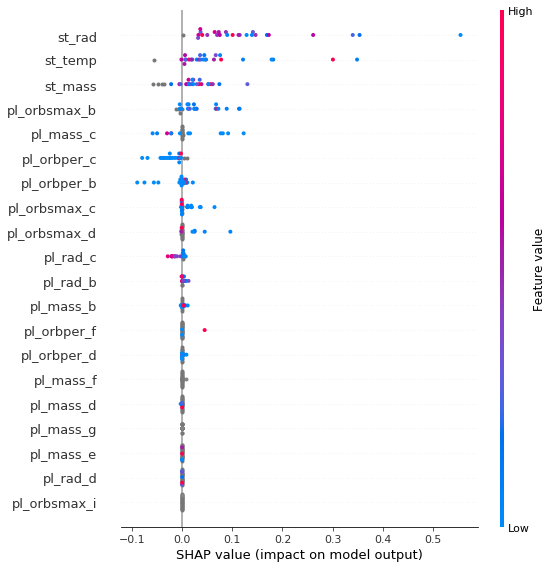

In [75]:
shap.initjs()
shap_all_values = explainer.shap_values(X_test_system[X_test_system_result['prob'] > 0.05])

shap.summary_plot(shap_all_values,X_test_system[X_test_system_result['prob'] > 0.05], feature_names=X_test_system.columns);

# Linear Model

In [76]:

imputer = IterativeImputer(max_iter=100, random_state=0)
X_train_system_imputed =  imputer.fit_transform(X_train_system)
X_test_system_imputed = imputer.transform(X_test_system)

model_system_linear = linear_model.SGDClassifier(loss='log', max_iter=1000,
                                                 n_jobs=-1, tol=1e-3,
                                                 class_weight='balanced')

model_system_linear.fit(X_train_system_imputed, y_train_system)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [77]:

y_pred_system_linear = model_system_linear.predict(X_test_system_imputed)

y_prob_system_linear = model_system_linear.predict_proba(X_test_system_imputed)[:,1]


print(roc_auc_score(y_test_system, y_prob_system_linear), '\n\n')


confusion_matrix(y_test_system, y_pred_system_linear)

0.7631578947368421 




array([[70, 63],
       [ 0,  6]])

In [0]:
solar_system_imputed = imputer.transform(solar_system_flatter.drop(columns=columns_drop))

In [79]:
model_system_linear.predict(solar_system_imputed)

array([ True])

In [80]:
baseline_system = [False]*len(y_test_system)

accuracy_score(y_test_system , baseline_system)

0.9568345323741008

In [81]:
accuracy_score(y_test_system, y_pred_system_linear)

0.5467625899280576

#Shapley summary plot

 92%|==================  | 128/139 [00:12<00:01]       

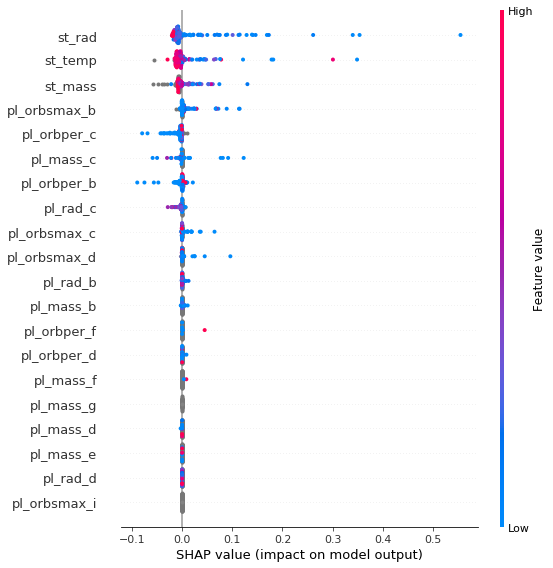

In [82]:
shap.initjs()
shap_all_values = explainer.shap_values(X_test_system)

shap.summary_plot(shap_all_values,X_test_system, feature_names=X_test_system.columns);